In [1]:
# load libraries and set plot parameters
import numpy as np
    
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_formats = set(['png', 'retina', 'svg'])

plt.style.use('revtex')
textwidth = 510

In [2]:
# Imports
import drprobe as drp
import shutil
import os
import time
from Stuff import ronchi
import scipy.constants as constants
import scalebars
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

In [3]:
# Imports for keras
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense, Dropout
from keras import metrics
#from keras import optimizers
from keras.models import load_model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from joblib import dump, load # for saving and loading models

Using TensorFlow backend.


In [18]:
# Some functions
def mrad_to_reciprocal_nm(alpha, ht=80):
    """
    Convert scattering angles from mrad to reciprocal nm.
    Parameters
    ----------
    alpha : float
        Angle in mrad.
    ht : float, optional
        High tension in kV.
    """
    return alpha / (1000 * electron_wavelength(ht))


def reciprocal_nm_to_mrad(f, ht=80):
    """
    Convert frequency from reciprocal nm to mrad.
    Parameters
    ----------
    f : float
        Frequency in reciprocal nm.
    ht : float, optional
        High tension in kV.
    """
    return f * 1000 * electron_wavelength(ht)


def electron_wavelength(ht):
    """
    Returns electron wavelenght in nm.
    Parameters
    ----------
    ht : float
        High tension in kV.
    """
    ec = constants.elementary_charge
    me = constants.m_e
    momentum = 2 * me * ec * ht * 1000 * (1 + ec * ht * 1000 / (2 * me * constants.c ** 2))
    wavelength = constants.h / np.sqrt(momentum) * 1e9  # in nm

    return wavelength


def figsize(scale, height=None, textwidth=448.1309):
    """
    Calculates ideal matplotlib Figure size, according to the desirde scale.
    :param scale: Fraction of Latex graphic input (scale*\textwidth)
    :param height: figure height = figure width * height
    :param textwidth:
    :return:
    """
    fig_width_pt = textwidth                         # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27                       # Convert pt to inch
    golden_mean = constants.golden_ratio - 1            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt * inches_per_pt * scale    # width in inches
    if height is None:
        fig_height = fig_width * golden_mean              # height in inches
    else:
        fig_height = fig_width * height
    fig_size = [fig_width, fig_height]

    return fig_size


def savefig(filename, formats=None, pgf=True, bbox_inches=None, pad_inches=None, dpi=300,
            pdf=True):
    if formats is None:
        if pgf:
            plt.savefig('{}.pgf'.format(filename), bbox_inches=bbox_inches)
        if pdf:
            plt.savefig('{}.pdf'.format(filename), bbox_inches=bbox_inches, dpi=dpi, pad_inches=pad_inches)
    else:
        if type(formats) is list or type(formats) is tuple:
            for fmt in formats:
                plt.savefig('{}.{}'.format(filename, fmt),
                            bbox_inches=bbox_inches, dpi=dpi, pad_inches=pad_inches)
    #plt.savefig('{}.png'.format(filename), bbox_inches=bbox_inches, dpi=dpi,
                # pad_inches=pad_inches)
        
def pretty_colorbar(fig, axs, im, position='top', pad=0.1, width=0.03, cbar_label=None,
                    constrain_ticklabels=False, ticks=None, ticklabels=None):
    """
    Creates a pretty colorbar, aligned with figure axes.

    Parameters
    ----------
    fig : matplotlib.figure object
        The figure object that contains the matplotlib axes and artists.
    axs : matplotlib.axes or list of matplotlib.axes
        The axes object(s), where the colorbar is drawn.
        Only provide those axes, which the colorbar will span.
    im : matplotlib object, mappable
        Mappable matplotlib object.
    position : str, optional
        The position defines the location of the colorbar. One of 'top', 'bottom', 'left' or
        'right'.
    pad : float, optional
        Defines the spacing between the axes and colorbar axis. Is given in figure fraction.
    width : float, optional
        Width of the colorbar given in figure fraction.
    cbar_label : string, optional
        Colorbar label
    constrain_ticklabels : bool, optional
        Allows to slightly shift the outermost ticklabels, such that they do not exceed the cbar
        axis.
    ticks : list, np.ndarray, optional
        List of cbar ticks
    ticklabels : list, np.ndarray, optional
        List of cbar ticklabels
    -----------
    Returns the colorbar object
    """
    if isinstance(axs, (tuple, list, np.ndarray)):
        p = []
        for ax in axs:
            p.append(ax.get_position().get_points().flatten())
    else:
        p = [axs.get_position().get_points().flatten()]

    if position == 'top':
        ax_cbar = fig.add_axes([p[0][0], 1-pad, p[-1][2]-p[0][0], width])
        cb = plt.colorbar(im, cax=ax_cbar, orientation='horizontal')
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')
    elif position == 'bottom':
        ax_cbar = fig.add_axes([p[0][0], pad, p[-1][2] - p[0][0], width])
        cb = plt.colorbar(im, cax=ax_cbar, orientation='horizontal')
        cb.ax.xaxis.set_ticks_position('bottom')
        cb.ax.xaxis.set_label_position('bottom')
    elif position == 'right':
        ax_cbar = fig.add_axes([1-pad, p[0][1], width, p[0][3] - p[0][1]])
        cb = plt.colorbar(im, cax=ax_cbar, orientation='vertical')
        cb.ax.yaxis.set_ticks_position('right')
        cb.ax.yaxis.set_label_position('right')
    elif position == 'left':
        ax_cbar = fig.add_axes([pad, p[0][1], width, p[0][3] - p[0][1]])
        cb = plt.colorbar(im, cax=ax_cbar, orientation='vertical')
        cb.ax.yaxis.set_ticks_position('left')
        cb.ax.yaxis.set_label_position('left')

    # Colorbar label
    if cbar_label is not None:
        cb.set_label(r'{}'.format(cbar_label))

    # Ticks and ticklabels
    if ticks:
        cb.set_ticks(ticks)
    if ticklabels:
        cb.set_ticklabels(ticklabels)

    # Constrain tick labels
    if constrain_ticklabels:
        if position == 'top' or position == 'bottom':
            t = cb.ax.get_xticklabels()
            t[0].set_horizontalalignment('left')
            t[-1].set_horizontalalignment('right')
        elif position == 'left' or position == 'right':
            t = cb.ax.get_yticklabels()
            t[0].set_verticalalignment('top')
            t[-1].set_verticalalignment('bottom')

    return cb


def scalebar(ax, length, sampling, height=None, hidex=True, hidey=True, color='white',
             ecolor='black', loc=3, lw=0.5):
    """
    Provide height in pixels.
    """
    if height is None:
        height = length / (5 * sampling)

    scalebars.add_scalebar(ax, length/sampling, height, hidex=hidex, hidey=hidey,
                           color=color, ecolor=ecolor, loc=loc, lw=lw)

In [5]:
np.random.seed(42)

In [6]:
def rebin(a, shape):
    sh = (shape[0], a.shape[0] // shape[0], shape[1], a.shape[1] // shape[1])
    return a.reshape(sh).mean(-1).mean(1)

# Simulation parameters

In [7]:
# Lattice constants
ht = 300

a, b, c = np.genfromtxt('sim/cel/diamond_amorph.cel', skip_header=1, skip_footer=1, usecols=(1, 2, 3))[0]

nx, ny = 240, 240

nz = 64
nt = 140
scan_shape = (ny, nx)
sampling = np.array([b, a]) / np.asarray(scan_shape)

diff_shape = (ny, nx)
diff_sampling = (1 / b, 1 / a)

print('Scan sampling rate: {:.4f} nm/px'.format(sampling[0]))
print('Diffraction sampling rate: {:.4f} 1/nm/px'.format(diff_sampling[0]))
print('Thickness: {:.1f} nm'.format(c / nz * nt))

Scan sampling rate: 0.0149 nm/px
Diffraction sampling rate: 0.2803 1/nm/px
Thickness: 12.5 nm


In [8]:
# Cutoff values for outer and inner part of ronchigram
dd = int(mrad_to_reciprocal_nm(45, ht) / diff_sampling[0])
dd_inner = int((np.cos(np.pi/4) * mrad_to_reciprocal_nm(0.95*40, ht) / diff_sampling[0]))

print(dd)
input_shape = (1, 2*dd, 2*dd)

81


In [9]:
drp.celslc('sim/cel/diamond_amorph.cel', 'sim/slc/amorph_C', 
           ht=ht, nx=nx, ny=ny, nz=nz, absorb=True, output=False)

In [10]:
# Setup MSA parameters
msa = drp.MsaPrm()

msa.conv_semi_angle = 40
msa.outer_radius_ann_det = 300
msa.wavelength = ronchi.electron_wavelength(300)

msa.h_scan_frame_size = a
msa.v_scan_frame_size = b
msa.scan_columns = scan_shape[1]
msa.scan_rows = scan_shape[0]
msa.super_cell_x = 1
msa.super_cell_y = 1
msa.super_cell_z = 1
msa.slice_files = 'sim/slc/amorph_C'
msa.number_of_slices = nz
msa.det_readout_period = nt
msa.tot_number_of_slices = nt

msa.save_msa_prm('sim/prm/msa.prm', random_slices=True)

# Examples

In [27]:
# Simulate or load example data
img_defocused = []
for f in np.arange(-120, 130, 10):
    msa.aberrations_dict = {1: (f, 0)}
    msa.save_msa_prm('sim/prm/msa.prm', random_slices=True)
    try:
        img = np.fromfile('sim/img/examples/img_f{:.0f}nm_px000_py000_pdif_tot_sl140.dat'.format(f), 
                      dtype='float32').reshape((nx, ny)).T
    except:
        drp.commands.msa('sim/prm/msa.prm', 'sim/img/examples/img_f{:.0f}nm.dat'.format(f), 
                         px=0, py=0, pdif=True, output=False)
        img = np.fromfile('sim/img/examples/img_f{:.0f}nm_px000_py000_pdif_tot_sl140.dat'.format(f), 
                          dtype='float32').reshape((nx, ny)).T
    img_defocused.append(img)

-120 0.0 0.0002470313
-110 0.0 0.00020241071
-100 0.0 0.0002370658
-90 0.0 0.00020696926
-80 0.0 0.0001864305
-70 0.0 0.00023156294
-60 0.0 0.00020504613
-50 0.0 0.00020196961
-40 0.0 0.0001788959
-30 0.0 0.00017598814
-20 0.0 0.00014770553
-10 0.0 0.00014956495
0 0.0 0.00013205875
10 0.0 0.00015398534
20 0.0 0.00017301065
30 0.0 0.00016905434
40 0.0 0.00019336042
50 0.0 0.0001961221
60 0.0 0.00019558151
70 0.0 0.00018942647
80 0.0 0.00020557168
90 0.0 0.00019515624
100 0.0 0.00019426829
110 0.0 0.00021695385
120 0.0 0.00020855023


/Users/fwinkler/.conda/envs/fw_tensorflow_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


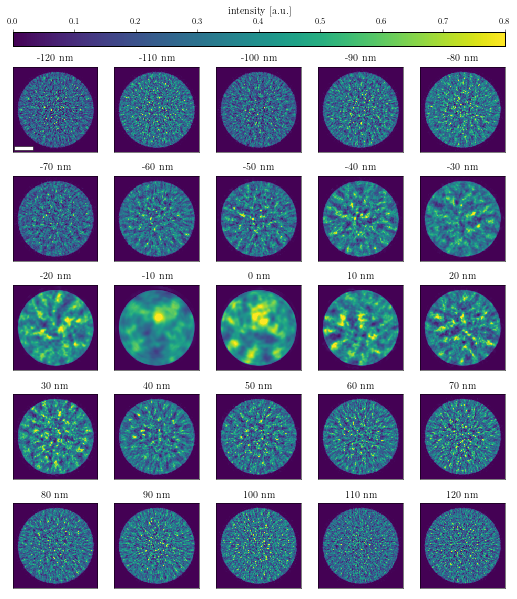

In [29]:
# Plot example data
fig, axs = plt.subplots(5, 5, figsize=figsize(1.25, 1.1, textwidth))
axs = axs.ravel()
for i, f in enumerate(np.arange(-120, 130, 10)):
    img = np.fft.fftshift(img_defocused[i])[int(nx/2 - dd):int(nx/2+dd), int(nx/2 - dd):int(nx/2+dd)]
    im = axs[i].imshow(img / np.max(img), cmap='viridis', clim=(0, 0.8))
    #axs[i].axis('off')
    axs[i].set_title('{:d} nm'.format(f))
    #if i == 0:
        #r = Rectangle((int(img.shape[0]/2)-dd_inner, int(img.shape[1]/2)-dd_inner), 2*dd_inner, 2*dd_inner,
        #              edgecolor='white', lw=1, linestyle='solid', facecolor='none')
        #axs[i].add_patch(r)
                      
    if i == 0:
        scalebar(axs[i], 20, reciprocal_nm_to_mrad(diff_sampling[0], ht))
    else:
        scalebar(axs[i], 0, reciprocal_nm_to_mrad(diff_sampling[0], ht))
        
    cb = pretty_colorbar(fig, [axs[0], axs[4]], im, cbar_label='intensity [a.u.]', width=0.02, pad=0.095)
    
savefig('Images/defocused_ronchi_example', formats=['png'], bbox_inches='tight')

## Double size

In [65]:
# Lattice constants
a_double, b_double, c_double = np.genfromtxt('sim/cel/diamond_amorph_double.cel', 
                                             skip_header=1, skip_footer=1, usecols=(1, 2, 3))[0]

In [66]:
drp.celslc('sim/cel/diamond_amorph_double.cel', 'sim/slc/amorph_C_double', 
           ht=ht, nx=nx*2, ny=ny*2, nz=nz, absorb=True, output=False)

In [67]:
# Setup MSA parameters
msa = drp.MsaPrm()

msa.conv_semi_angle = 40
msa.outer_radius_ann_det = 300
msa.wavelength = ronchi.electron_wavelength(300)

msa.h_scan_frame_size = a_double
msa.v_scan_frame_size = b_double
msa.scan_columns = scan_shape[1]
msa.scan_rows = scan_shape[0]
msa.super_cell_x = 1
msa.super_cell_y = 1
msa.super_cell_z = 1
msa.slice_files = 'sim/slc/amorph_C_double'
msa.number_of_slices = nz
msa.det_readout_period = nt
msa.tot_number_of_slices = nt

msa.save_msa_prm('sim/prm/msa_double.prm', random_slices=True)

In [69]:
# Simulate or load example data
img_defocused_double = []
for f in np.arange(-120, 130, 10):
    msa.aberrations_dict = {1: (f, 0)}
    msa.save_msa_prm('sim/prm/msa_double.prm', random_slices=True)
    try:
        img = np.fromfile('sim/img/examples_double/img_f{:.0f}nm_px000_py000_pdif_tot_sl140.dat'.format(f), 
                      dtype='float32').reshape((nx*2, ny*2)).T
    except:
        drp.commands.msa('sim/prm/msa_double.prm', 'sim/img/examples_double/img_f{:.0f}nm.dat'.format(f), 
                         px=0, py=0, pdif=True, output=False)
        img = np.fromfile('sim/img/examples_double/img_f{:.0f}nm_px000_py000_pdif_tot_sl140.dat'.format(f), 
                          dtype='float32').reshape((nx*2, ny*2)).T
        
    img_defocused_double.append(rebin(img, (nx, ny)))

In [77]:
np.mean(img_defocused[2])

1.7225088e-05

In [78]:
np.mean(img_defocused_double[2])

4.3063274e-06

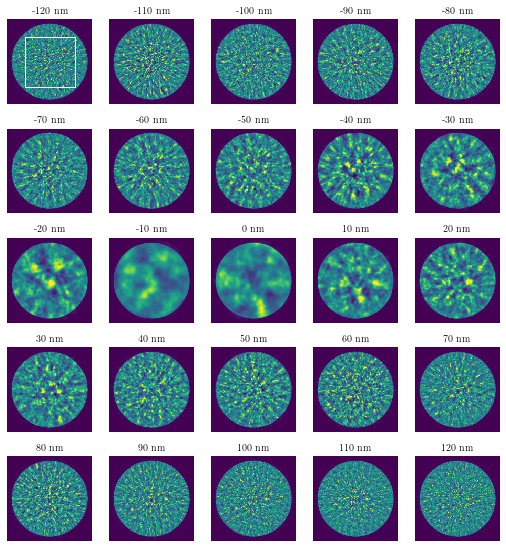

In [84]:
# Plot example data
fig, axs = plt.subplots(5, 5, figsize=figsize(1.25, 1.1, textwidth))
axs = axs.ravel()
for i, f in enumerate(np.arange(-120, 130, 10)):
    img = np.fft.fftshift(img_defocused_double[i])[int(nx/2 - dd):int(nx/2+dd), int(nx/2 - dd):int(nx/2+dd)]
    axs[i].imshow(img, cmap='viridis', clim=(0, 3.2e-5))
    axs[i].axis('off')
    axs[i].set_title('{:d} nm'.format(f))
    if i == 0:
        r = Rectangle((int(img.shape[0]/2)-dd_inner, int(img.shape[1]/2)-dd_inner), 2*dd_inner, 2*dd_inner,
                      edgecolor='white', lw=1, linestyle='solid', facecolor='none')
        axs[i].add_patch(r)
    
#savefig('Images/defocused_ronchi_example', formats=['png'], bbox_inches='tight')

# Training with full Ronchigram (45 mrad)

Calculate training and validation data with up to 45 mrad in the ronchigrams and the following parameters:

    - sample: amorphous carbon with a thickness randomly chosen between 10-15 nm
    - diffraction sampling: 0.2803 1/nm/px (similar to exp. data at camera length 77 mm)
    - high tension: 300 kV
    - semi-convergence angle: 40 mrad
    - focus variation from 0 nm to +100 nm (so only positive values)
    - included Medipix MTF (and pixel sinc)

In [95]:
# Load or calculate validation data set (20.000 images)
if input('Load test data? (y or n)') == 'y':
    X_test = np.load('data/X_test_20_200_5_45mrad.npy')
    Y_test = np.load('data/Y_test_20_200_5_45mrad.npy')
else:
    r = ronchi.RonchiTrainer(n_processes=20, n_batches=200, ly=5, dd=dd, thick_wobble=0.2,
                             msa_obj=msa, ht=300, nx=nx, ny=ny, mtf='sim/Merlin-300keV-SPCM100.mtf')
    aber_dict = ronchi.create_empty_aber_dict()
    aber_dict['C1'] = (0, 100)

    X_test, Y_test = r(aber_dict)
    
    r.finalize()
    np.save('data/X_test_20_200_5_45mrad.npy', X_test)
    np.save('data/Y_test_20_200_5_45mrad.npy', Y_test)

Load test data? (y or n)y


In [96]:
# Load or calculate training data set (100.000 images)
if input('Load train data? (y or n)') == 'y':
    X_train = np.load('data/X_train_20_500_10_45mrad.npy')
    Y_train = np.load('data/Y_train_20_500_10_45mrad.npy')
else:
    r = ronchi.RonchiTrainer(n_processes=20, n_batches=500, ly=10, dd=dd, thick_wobble=0.2,
                             msa_obj=msa, ht=300, nx=nx, ny=ny, mtf='sim/Merlin-300keV-SPCM100.mtf')
    aber_dict = ronchi.create_empty_aber_dict()
    aber_dict['C1'] = (0, 100)

    X_train, Y_train = r(aber_dict)
    
    r.finalize()
    np.save('data/X_train_20_500_10_45mrad.npy', X_train)
    np.save('data/Y_train_20_500_10_45mrad.npy', Y_train)

Load train data? (y or n)y


In [97]:
# Split apart a validation data set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42, shuffle=True)

In [34]:
def plot_results(Y_test, Y_pred, H_conc, defoci=None, guide_line=False):
    fig, axs = plt.subplots(1, 3, figsize=figsize(1., 0.35, textwidth))

    axs[0].plot(H_conc['acc'], label='train')
    axs[0].plot(H_conc['val_acc'], label='test')
    axs[0].set_ylabel('Accuracy')

    axs[1].plot(H_conc['loss'], label='train')
    axs[1].plot(H_conc['val_loss'], label='test')
    axs[1].set_ylabel('Loss')

    for ax in axs[:-1]:
        ax.set_xlabel('Epoch')
        ax.legend()


    mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                           [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
    mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
    im = axs[2].imshow(mat.T, 
                    origin='lower',
                    cmap='nipy_spectral',
                    vmin=0, #vmax=1,
                   )

    cb = plt.colorbar(im)
    cb.set_label('Accuracy')

    axs[2].set_xlabel('true focus [nm]')
    axs[2].set_ylabel('predicted focus [nm]')
    axs[2].set_title('Confusion Matrix');
    
    if guide_line:
        axs[2].plot([np.min(defoci), np.max(defoci)], [np.min(defoci), np.max(defoci)], lw=2, color='white')
    
    #return fig, axs

In [35]:
def build_model_categorical(input_shape, n_classes, n_neurons=1.0, dropout=0.2, kernel_size=(5, 5), 
                            categorical=True):
    model = Sequential()
    model.add(Conv2D(int(32*n_neurons), kernel_size=kernel_size, padding="same", input_shape=input_shape, 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format='channels_first'))
    model.add(Dropout(dropout))

    model.add(Conv2D(int(64*n_neurons), kernel_size=kernel_size, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first"))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(int(128*n_neurons), kernel_size=kernel_size, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first"))
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(int(400*n_neurons), activation='relu'))
    
    if categorical:
        model.add(Dense(n_classes), activation='softmax')
    else:
        model.add(Dense(int(200*n_neurons), activation='relu'))
        model.add(Dense(1))
    return model

In [36]:
def categorical(y, elem):
    abc = np.zeros((len(y), len(elem)))
    pos = np.argmin(np.abs(elem - y[:, np.newaxis]), axis=1)
    for i, f in enumerate(y):
        abc[i, pos[i]] = 1
    return abc

## Finding the optimum dropout value (categorical data) - kernel size 5

In [37]:
# define the training parameters

# defocus
C1_max = 100
C1_resolution = 2
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (0, C1_max)

# training
n_processes = 20
n_batches = 500
ly = 10
dd = dd
n_fit_calls = 1

# write params in dictionaly
training_params = {}
training_params['C1_max'] = C1_max
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

In [38]:
# Build the model
n_classes = len(defoci)
n_epoch = 200
batch_size = 250

In [19]:
# Massive training search
nid = 'A#01'
n_neurons = 1

if input('Train model? (y or n)') == 'y':
    for drop in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]:
        print('---------------')
        print('dropout value: {:.2f}'.format(drop))
        print('---------------')
    
        # Build the model
        model = build_model_categorical(input_shape, n_classes, dropout=drop, n_neurons=n_neurons)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
        mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons), 
                             monitor='val_loss', mode='min', save_best_only=True, verbose=1)

        # Prepare a list to save the history of the model
        H = []
        H_conc = {}

        # Save the training parameters
        np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}_categorical'.format(nid, drop, n_neurons), training_params)
        print(training_params)

        H.append(model.fit(X_train, categorical(Y_train, defoci), 
                           batch_size=batch_size, 
                           epochs=n_epoch, 
                           verbose=1,
                           validation_data=(X_test, categorical(Y_test, defoci)), 
                           callbacks=[es, mc],
                           shuffle=True))
                
        # Concatanete the results for all training iterations and save them to dictionary    
        for key in H[0].history.keys():
            H_conc[key] = np.concatenate([h.history[key] for h in H])
        np.save('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), H_conc)

Train model? (y or n)n


----  0.00  ----
loaded y_pred
Score:  [2.53872448 0.1875    ]
----  0.05  ----
loaded y_pred
Score:  [2.37809358 0.16435   ]
----  0.10  ----
loaded y_pred
Score:  [2.37030421 0.15925   ]
----  0.15  ----
loaded y_pred
Score:  [2.41602659 0.1651    ]
----  0.20  ----
loaded y_pred
Score:  [2.5529939 0.1788   ]
----  0.25  ----
loaded y_pred
Score:  [2.625797 0.1377  ]
saved score


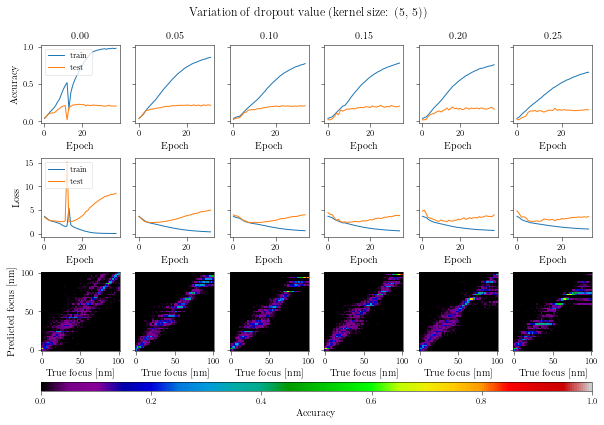

In [45]:
# Plot
fig, axs = plt.subplots(3, 6, figsize=figsize(1.4, 0.6, textwidth), sharey='row')

nid = 'A#01'
n_neurons = 1
scores = []

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
for i, drop in enumerate([0.0, 0.05, 0.1, 0.15, 0.2, 0.25]):
    print('----  {:.2f}  ----'.format(drop))
    # Load the data
    H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), 
                     allow_pickle=True).item()
    
    try:
        Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons))
        model_loaded = False
        print('loaded y_pred')
    except:
        model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons))
        model_loaded = True
        Y_pred = model.predict(X_test[:])
        Y_pred = defoci[np.argmax(Y_pred, axis=1)]
        print('Saved y_pred')
        np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), Y_pred)
    
    if scores_calc:
        if not model_loaded:
            model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons))
        score = model.evaluate(X_test, categorical(Y_test, defoci))
        scores.append(score)
        print('calculated score')
    print('Score: ', scores[i])
    
    # Accuracy
    axs[0, i].plot(H_conc['acc'], label='train')
    axs[0, i].plot(H_conc['val_acc'], label='test')
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_aspect(1.0/axs[0, i].get_data_ratio())
    
    # Loss
    axs[1, i].plot(H_conc['loss'], label='train')
    axs[1, i].plot(H_conc['val_loss'], label='test')
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_aspect(1.0/axs[1, i].get_data_ratio())
    
    # Confusion Matrix
    mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                           [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
    mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
    im = axs[2, i].imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)
    axs[2, i].set_xticks(defoci[::25]/C1_resolution)
    axs[2, i].set_yticks(defoci[::25]/C1_resolution)
    axs[2, i].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_xlabel('True focus [nm]')
    
    axs[0, i].set_title('{:.2f}'.format(drop))
    
np.save('data/scores_{}.npy'.format(nid), scores)
print('saved score')

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='bottom', pad=0.05, width=0.02, cbar_label='Accuracy')
    
axs[0, 0].set_ylabel('Accuracy');
axs[1, 0].set_ylabel('Loss')
axs[2, 0].set_ylabel('Predicted focus [nm]')
axs[0, 0].legend(loc=2)
axs[1, 0].legend(loc=2)

fig.suptitle('Variation of dropout value (kernel size: (5, 5))', y=0.95);

savefig('Images/Results_{}'.format(nid), formats=['png'], bbox_inches='tight')

In [46]:
# Plot the model as a graph
nid = 'A#01'
plot_model(model, to_file='Images/model_{}.png'.format(nid), show_shapes=True)

NameError: name 'model' is not defined

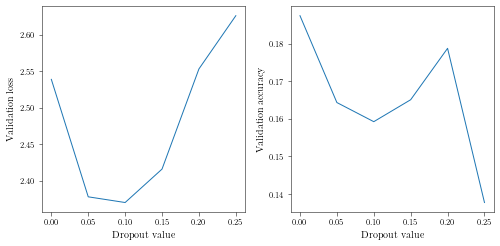

In [47]:
# Plot scores
nid = 'A#01'

fig, axs = plt.subplots(1, 2, figsize=figsize(1, 0.5, textwidth))
axs[0].plot([0.0, 0.05, 0.1, 0.15, 0.2, 0.25], [s[0] for s in scores])
axs[0].set_xlabel('Dropout value')
axs[0].set_ylabel('Validation loss')

axs[1].plot([0.0, 0.05, 0.1, 0.15, 0.2, 0.25], [s[1] for s in scores])
axs[1].set_xlabel('Dropout value')
axs[1].set_ylabel('Validation accuracy');

fig.tight_layout()
savefig('Images/Scores_{}'.format(nid), formats=['png'], bbox_inches='tight')

## Finding the optimum dropout value (categorical data) - kernel size 3

In [53]:
# define the training parameters

# defocus
C1_max = 100
C1_resolution = 2
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (0, C1_max)

# training
n_processes = 20
n_batches = 500
ly = 10
dd = dd
n_fit_calls = 1

# write params in dictionaly
training_params = {}
training_params['C1_max'] = C1_max
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

In [54]:
# Build the model
n_classes = len(defoci)
n_epoch = 200
batch_size = 250

In [55]:
# Massive training search
nid = 'A#02'
n_neurons = 1

if input('Train model? (y or n)') == 'y':
    for drop in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]:
        print('---------------')
        print('dropout value: {:.2f}'.format(drop))
        print('---------------')
    
        # Build the model
        model = build_model_categorical(input_shape, n_classes, dropout=drop, n_neurons=n_neurons, 
                                        kernel_size=(3, 3))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
        mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons), 
                             monitor='val_loss', mode='min', save_best_only=True, verbose=1)

        # Prepare a list to save the history of the model
        H = []
        H_conc = {}

        # Save the training parameters
        np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}_categorical'.format(nid, drop, n_neurons), training_params)
        print(training_params)

        H.append(model.fit(X_train, categorical(Y_train, defoci), 
                           batch_size=batch_size, 
                           epochs=n_epoch, 
                           verbose=1,
                           validation_data=(X_test, categorical(Y_test, defoci)), 
                           callbacks=[es, mc],
                           shuffle=True))
                
        # Concatanete the results for all training iterations and save them to dictionary    
        for key in H[0].history.keys():
            H_conc[key] = np.concatenate([h.history[key] for h in H])
        np.save('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical'.format(nid, drop, n_neurons), H_conc)

Train model? (y or n)


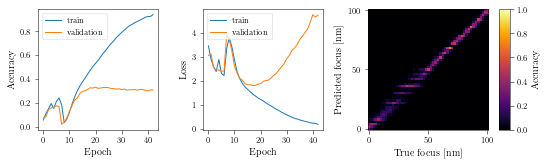

In [85]:
# Condensed plot
fig, axs = plt.subplots(1, 3, figsize=figsize(1, 0.4, textwidth))
nid = 'A#02'
n_neurons = 1
drop = 0.0

H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), 
                    allow_pickle=True).item()
    
Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons))



# Accuracy
axs[0].plot(H_conc['acc'], label='train')
axs[0].plot(H_conc['val_acc'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_aspect(1.0/axs[0].get_data_ratio())

# Loss
axs[1].plot(H_conc['loss'], label='train')
axs[1].plot(H_conc['val_loss'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_aspect(1.0/axs[1].get_data_ratio())

# Confusion Matrix
mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                       [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
im = axs[2].imshow(mat.T, origin='lower', cmap='inferno', vmin=0, vmax=1)
axs[2].set_xticks(defoci[::25]/C1_resolution)
axs[2].set_yticks(defoci[::25]/C1_resolution)
axs[2].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs[2].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs[2].set_xlabel('True focus [nm]')

#axs[0].set_title('{:.2f}'.format(drop))
#fig.suptitle('categorical data')

axs[0].set_ylabel('Accuracy');
axs[1].set_ylabel('Loss')
axs[2].set_ylabel('Predicted focus [nm]')
axs[0].legend(loc=2)
axs[1].legend(loc=2)

plt.tight_layout()

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='right', pad=0.01, width=0.02, cbar_label='Accuracy')

savefig('Images/Results_{}_condensed'.format(nid), formats=['png'], bbox_inches='tight')

----  0.00  ----
loaded y_pred
Score:  [1.80031755 0.31095   ]
----  0.05  ----
loaded y_pred
Score:  [2.17089375 0.2315    ]
----  0.10  ----
loaded y_pred
Score:  [2.1867837 0.2189   ]
----  0.15  ----
loaded y_pred
Score:  [2.27522805 0.23465   ]
----  0.20  ----
loaded y_pred
Score:  [2.27603608 0.21065   ]
----  0.25  ----
loaded y_pred
Score:  [2.37788217 0.18185   ]
saved score


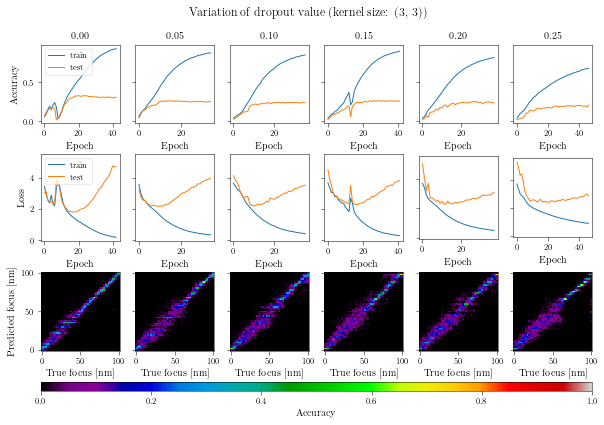

In [68]:
# Plot
fig, axs = plt.subplots(3, 6, figsize=figsize(1.4, 0.6, textwidth), sharey='row')

nid = 'A#02'
n_neurons = 1
scores = []

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
for i, drop in enumerate([0.0, 0.05, 0.1, 0.15, 0.2, 0.25]):
    print('----  {:.2f}  ----'.format(drop))
    # Load the data
    H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), 
                     allow_pickle=True).item()
    
    try:
        Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons))
        model_loaded = False
        print('loaded y_pred')
    except:
        model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons))
        model_loaded = True
        Y_pred = model.predict(X_test[:])
        Y_pred = defoci[np.argmax(Y_pred, axis=1)]
        print('Saved y_pred')
        np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), Y_pred)
    
    if scores_calc:
        if not model_loaded:
            model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons))
        score = model.evaluate(X_test, categorical(Y_test, defoci))
        scores.append(score)
        print('calculated score')
    print('Score: ', scores[i])
    
    # Accuracy
    axs[0, i].plot(H_conc['acc'], label='train')
    axs[0, i].plot(H_conc['val_acc'], label='test')
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_aspect(1.0/axs[0, i].get_data_ratio())
    
    # Loss
    axs[1, i].plot(H_conc['loss'], label='train')
    axs[1, i].plot(H_conc['val_loss'], label='test')
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_aspect(1.0/axs[1, i].get_data_ratio())
    
    # Confusion Matrix
    mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                           [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
    mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
    im = axs[2, i].imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)
    axs[2, i].set_xticks(defoci[::25]/C1_resolution)
    axs[2, i].set_yticks(defoci[::25]/C1_resolution)
    axs[2, i].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_xlabel('True focus [nm]')
    
    axs[0, i].set_title('{:.2f}'.format(drop))
    
np.save('data/scores_{}.npy'.format(nid), scores)
print('saved score')

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='bottom', pad=0.05, width=0.02, cbar_label='Accuracy')
    
axs[0, 0].set_ylabel('Accuracy');
axs[1, 0].set_ylabel('Loss')
axs[2, 0].set_ylabel('Predicted focus [nm]')
axs[0, 0].legend(loc=2)
axs[1, 0].legend(loc=2)

fig.suptitle('Variation of dropout value (kernel size: (3, 3))', y=0.95);

savefig('Images/Results_{}'.format(nid), formats=['png'], bbox_inches='tight')

In [ ]:
# Plot the model as a graph
nid = 'A#02'
plot_model(model, to_file='Images/model_{}.png'.format(nid), show_shapes=True)

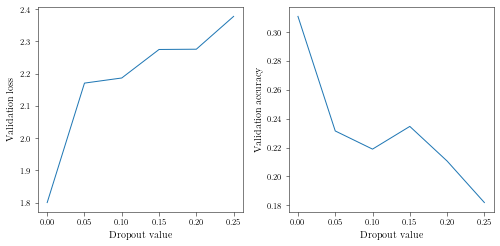

In [57]:
# Plot scores
nid = 'A#02'

fig, axs = plt.subplots(1, 2, figsize=figsize(1, 0.5, textwidth))
axs[0].plot([0.0, 0.05, 0.1, 0.15, 0.2, 0.25], [s[0] for s in scores])
axs[0].set_xlabel('Dropout value')
axs[0].set_ylabel('Validation loss')

axs[1].plot([0.0, 0.05, 0.1, 0.15, 0.2, 0.25], [s[1] for s in scores])
axs[1].set_xlabel('Dropout value')
axs[1].set_ylabel('Validation accuracy');

fig.tight_layout()
savefig('Images/Scores_{}'.format(nid), formats=['png'], bbox_inches='tight')

## Finding the optimum dropout value (non-categorical data) - kernel size 3

In [99]:
# define the training parameters

# defocus
C1_max = 100
C1_resolution = 2
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (0, C1_max)

# training
n_processes = 20
n_batches = 500
ly = 10
dd = dd
n_fit_calls = 1

# write params in dictionaly
training_params = {}
training_params['C1_max'] = C1_max
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

In [100]:
# Build the model
n_classes = len(defoci)
n_epoch = 200
batch_size = 256

In [101]:
# Massive training search
nid = 'A#03'
n_neurons = 1
drops = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
if input('Train model? (y or n)') == 'y':
    for drop in drops:
        print('---------------')
        print('dropout value: {:.2f}'.format(drop))
        print('---------------')
    
        # Build the model
        model = build_model_categorical(input_shape, n_classes, dropout=drop, n_neurons=n_neurons, 
                                        kernel_size=(3, 3), categorical=False)
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
        mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n_neurons), 
                             monitor='val_loss', mode='min', save_best_only=True, verbose=1)

        # Prepare a list to save the history of the model
        H = []
        H_conc = {}

        # Save the training parameters
        np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}'.format(nid, drop, n_neurons), training_params)
        print(training_params)

        H.append(model.fit(X_train, Y_train, 
                           batch_size=batch_size, 
                           epochs=n_epoch, 
                           verbose=1,
                           validation_data=(X_val, Y_val), 
                           #validation_split=0.1,
                           callbacks=[es, mc],
                           shuffle=True))
                
        # Concatanete the results for all training iterations and save them to dictionary    
        for key in H[0].history.keys():
            H_conc[key] = np.concatenate([h.history[key] for h in H])
        np.save('histories/{}_history_drop{:.2f}_nn{:.1f}'.format(nid, drop, n_neurons), H_conc)

Train model? (y or n)


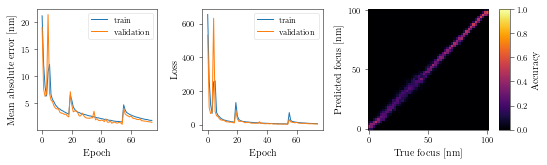

In [102]:
# Condensed plot
fig, axs = plt.subplots(1, 3, figsize=figsize(1, 0.4, textwidth))
nid = 'A#03'
n_neurons = 1
drop = 0.05

H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n_neurons), 
                    allow_pickle=True).item()
    
Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n_neurons))



# Accuracy
axs[0].plot(H_conc['mean_absolute_error'], label='train')
axs[0].plot(H_conc['val_mean_absolute_error'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_aspect(1.0/axs[0].get_data_ratio())

# Loss
axs[1].plot(H_conc['loss'], label='train')
axs[1].plot(H_conc['val_loss'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_aspect(1.0/axs[1].get_data_ratio())

# Confusion Matrix
mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                       [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
im = axs[2].imshow(mat.T, origin='lower', cmap='inferno', vmin=0, vmax=1)
axs[2].set_xticks(defoci[::25]/C1_resolution)
axs[2].set_yticks(defoci[::25]/C1_resolution)
axs[2].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs[2].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs[2].set_xlabel('True focus [nm]')

#axs[0].set_title('{:.2f}'.format(drop))
#fig.suptitle('non-categorical data')

axs[0].set_ylabel('Mean absolute error [nm]');
axs[1].set_ylabel('Loss')
axs[2].set_ylabel('Predicted focus [nm]')
axs[0].legend(loc=1)
axs[1].legend(loc=1)

plt.tight_layout()

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='right', pad=0.01, width=0.02, cbar_label='Accuracy')

savefig('Images/Results_{}_condensed'.format(nid), formats=['png'], bbox_inches='tight')

----  0.00  ----
loaded y_pred
Score:  [14.21442929  2.97803358]
----  0.05  ----
loaded y_pred
Score:  [7.49387637 2.02575493]
----  0.10  ----
loaded y_pred
Score:  [11.25611233  2.52476107]
----  0.15  ----
loaded y_pred
Score:  [10.50181571  2.4356487 ]
----  0.20  ----
loaded y_pred
Score:  [15.12054169  2.87884394]
----  0.25  ----
loaded y_pred
Score:  [22.91345877  3.41522577]
----  0.30  ----
loaded y_pred
Score:  [32.7947481   4.22002323]
----  0.40  ----
loaded y_pred
Score:  [88.37981594  6.98060722]
----  0.50  ----
loaded y_pred
Score:  [1841.54837786   35.74671202]
saved score


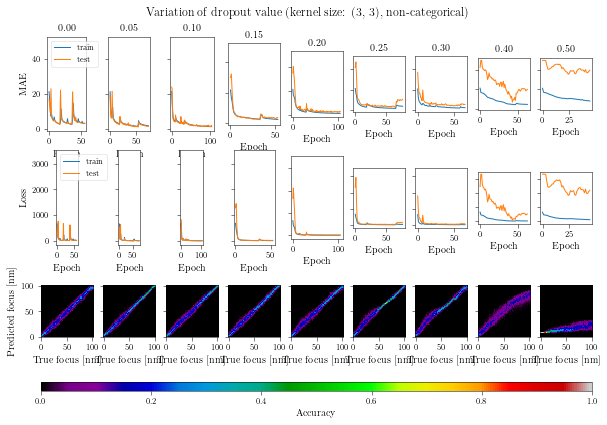

In [74]:
# Plot
fig, axs = plt.subplots(3, len(drops), figsize=figsize(1.4, 0.6, textwidth), sharey='row')

nid = 'A#03'
n_neurons = 1
scores = []

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
for i, drop in enumerate(drops):
    print('----  {:.2f}  ----'.format(drop))
    # Load the data
    H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n_neurons), 
                     allow_pickle=True).item()
    
    try:
        Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n_neurons))
        model_loaded = False
        print('loaded y_pred')
    except:
        model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n_neurons))
        model_loaded = True
        Y_pred = model.predict(X_test[:])
        #Y_pred = defoci[np.argmax(Y_pred, axis=1)]
        print('Saved y_pred')
        np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n_neurons), Y_pred)
    
    if scores_calc:
        if not model_loaded:
            model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n_neurons))
        score = model.evaluate(X_test, Y_test)
        scores.append(score)
        print('calculated score')
    print('Score: ', scores[i])
    
    # Accuracy
    axs[0, i].plot(H_conc['mean_absolute_error'], label='train')
    axs[0, i].plot(H_conc['val_mean_absolute_error'], label='test')
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_aspect(1.0/axs[0, i].get_data_ratio())
    
    # Loss
    axs[1, i].plot(H_conc['loss'], label='train')
    axs[1, i].plot(H_conc['val_loss'], label='test')
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_aspect(1.0/axs[1, i].get_data_ratio())
    
    # Confusion Matrix
    mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                           [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
    mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
    im = axs[2, i].imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)
    axs[2, i].set_xticks(defoci[::25]/C1_resolution)
    axs[2, i].set_yticks(defoci[::25]/C1_resolution)
    axs[2, i].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_xlabel('True focus [nm]')
    
    axs[0, i].set_title('{:.2f}'.format(drop))
    
np.save('data/scores_{}.npy'.format(nid), scores)
print('saved score')

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='bottom', pad=0.05, width=0.02, cbar_label='Accuracy')
    
axs[0, 0].set_ylabel('MAE');
axs[1, 0].set_ylabel('Loss')
axs[2, 0].set_ylabel('Predicted focus [nm]')
axs[0, 0].legend(loc=2)
axs[1, 0].legend(loc=2)

fig.suptitle('Variation of dropout value (kernel size: (3, 3), non-categorical)', y=0.95);

savefig('Images/Results_{}'.format(nid), formats=['png'], bbox_inches='tight')

In [52]:
# Plot the model as a graph
nid = 'A#03'
plot_model(model, to_file='Images/model_{}.png'.format(nid), show_shapes=True)

NameError: name 'model' is not defined

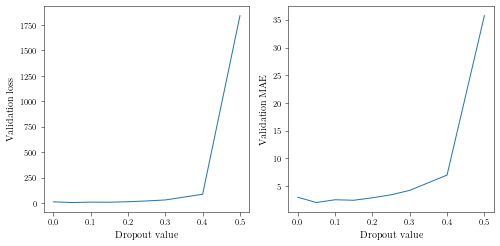

In [75]:
# Plot scores
nid = 'A#03'

fig, axs = plt.subplots(1, 2, figsize=figsize(1, 0.5, textwidth))
axs[0].plot(drops, [s[0] for s in scores])
axs[0].set_xlabel('Dropout value')
axs[0].set_ylabel('Validation loss')

axs[1].plot(drops, [s[1] for s in scores])
axs[1].set_xlabel('Dropout value')
axs[1].set_ylabel('Validation MAE');

fig.tight_layout()
savefig('Images/Scores_{}'.format(nid), formats=['png'], bbox_inches='tight')

## Finding the optimum number of neurons - kernel size: 3, drop: 0.

In [33]:
# define the training parameters

# defocus
C1_max = 100
C1_resolution = 2
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (0, C1_max)

# training
n_processes = 20
n_batches = 500
ly = 10
dd = dd
n_fit_calls = 1

# write params in dictionaly
training_params = {}
training_params['C1_max'] = C1_max
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

In [34]:
# Build the model
n_classes = len(defoci)
n_epoch = 200
batch_size = 250

In [35]:
# Massive training search
nid = 'B#01'
drop = 0.0

if input('Train model? (y or n)') == 'y':
    for n_neurons in [0.3, 0.5, 0.75, 1.0, 1.5, 2.0]:
        print('---------------')
        print('n_neurons: {:.2f}'.format(n_neurons))
        print('---------------')
    
        # Build the model
        model = build_model_categorical(input_shape, n_classes, dropout=drop, n_neurons=n_neurons, 
                                        kernel_size=(3, 3))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
        mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons), 
                             monitor='val_loss', mode='min', save_best_only=True, verbose=1)

        # Prepare a list to save the history of the model
        H = []
        H_conc = {}

        # Save the training parameters
        np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}_categorical'.format(nid, drop, n_neurons), 
                training_params)
        print(training_params)

        H.append(model.fit(X_train, categorical(Y_train, defoci), 
                           batch_size=batch_size, 
                           epochs=n_epoch, 
                           verbose=1,
                           validation_data=(X_test, categorical(Y_test, defoci)), 
                           callbacks=[es, mc],
                           shuffle=True))
                
        # Concatanete the results for all training iterations and save them to dictionary    
        for key in H[0].history.keys():
            H_conc[key] = np.concatenate([h.history[key] for h in H])
        np.save('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical'.format(nid, drop, n_neurons), H_conc)

Train model? (y or n)


----  0.30  ----
loaded y_pred
Score:  [1.99531286 0.2699    ]
----  0.50  ----
loaded y_pred
Score:  [2.16829925 0.19975   ]
----  0.75  ----
loaded y_pred
Score:  [2.27124391 0.1965    ]
----  1.00  ----
loaded y_pred
Score:  [2.24607912 0.19335   ]
----  1.50  ----
loaded y_pred
Score:  [2.21309981 0.203     ]
----  2.00  ----
loaded y_pred
Score:  [2.27124028 0.21485   ]
saved score


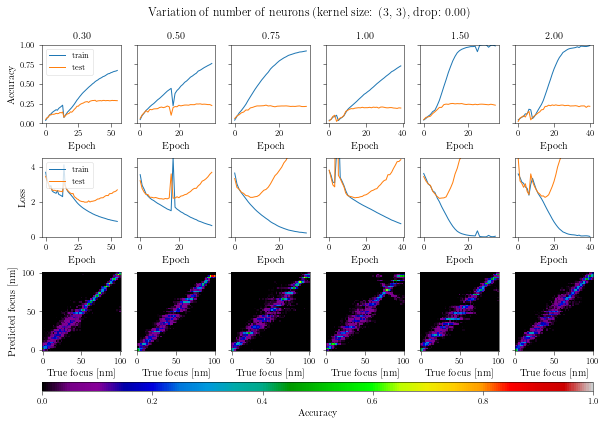

In [36]:
# Plot
fig, axs = plt.subplots(3, 6, figsize=figsize(1.4, 0.6, textwidth), sharey='row')

nid = 'B#01'
drop = 0.0
scores = []

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
for i, n_neurons in enumerate([0.3, 0.5, 0.75, 1.0, 1.5, 2.0]):
    print('----  {:.2f}  ----'.format(n_neurons))
    # Load the data
    H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), 
                     allow_pickle=True).item()
    
    try:
        Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons))
        model_loaded = False
        print('loaded y_pred')
    except:
        model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons))
        model_loaded = True
        Y_pred = model.predict(X_test[:])
        Y_pred = defoci[np.argmax(Y_pred, axis=1)]
        print('Saved y_pred')
        np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), Y_pred)
    
    if scores_calc:
        if not model_loaded:
            model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons))
        score = model.evaluate(X_test, categorical(Y_test, defoci))
        scores.append(score)
        print('calculated score')
    print('Score: ', scores[i])
    
    # Accuracy
    axs[0, i].plot(H_conc['acc'], label='train')
    axs[0, i].plot(H_conc['val_acc'], label='test')
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_ylim(0, 1)
    axs[0, i].set_aspect(1.0/axs[0, i].get_data_ratio())
    
    # Loss
    axs[1, i].plot(H_conc['loss'], label='train')
    axs[1, i].plot(H_conc['val_loss'], label='test')
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_ylim(0, 4.5)
    axs[1, i].set_aspect(1.0/axs[1, i].get_data_ratio())
    
    # Confusion Matrix
    mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                           [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
    mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
    im = axs[2, i].imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)
    axs[2, i].set_xticks(defoci[::25]/C1_resolution)
    axs[2, i].set_yticks(defoci[::25]/C1_resolution)
    axs[2, i].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_xlabel('True focus [nm]')
    
    axs[0, i].set_title('{:.2f}'.format(n_neurons))
    
np.save('data/scores_{}.npy'.format(nid), scores)
print('saved score')

#fig.tight_layout()

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='bottom', pad=0.05, width=0.02, cbar_label='Accuracy')
    
axs[0, 0].set_ylabel('Accuracy');
axs[1, 0].set_ylabel('Loss')
axs[2, 0].set_ylabel('Predicted focus [nm]')
axs[0, 0].legend(loc=2)
axs[1, 0].legend(loc=2)

fig.suptitle('Variation of number of neurons (kernel size: (3, 3), drop: {:.2f})'.format(drop), y=0.95);

savefig('Images/Results_{}'.format(nid), formats=['png'], bbox_inches='tight')

In [ ]:
# Plot the model as a graph
nid = 'B#01'
plot_model(model, to_file='Images/model_{}.png'.format(nid), show_shapes=True)

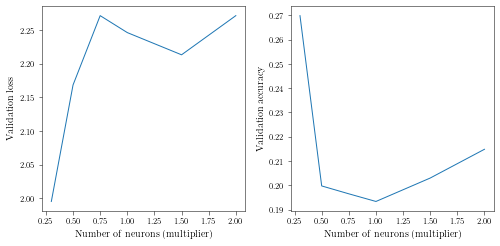

In [37]:
# Plot scores
nid = 'B#01'

fig, axs = plt.subplots(1, 2, figsize=figsize(1, 0.5, textwidth))
axs[0].plot([0.3, 0.5, 0.75, 1.0, 1.5, 2.0], [s[0] for s in scores])
axs[0].set_xlabel('Number of neurons (multiplier)')
axs[0].set_ylabel('Validation loss')

axs[1].plot([0.3, 0.5, 0.75, 1.0, 1.5, 2.0], [s[1] for s in scores])
axs[1].set_xlabel('Number of neurons (multiplier)')
axs[1].set_ylabel('Validation accuracy');

fig.tight_layout()
savefig('Images/Scores_{}'.format(nid), formats=['png'], bbox_inches='tight')

## Finding number of neurons (non-categorical data) - kernel size 3, drop 0.05

In [38]:
# define the training parameters

# defocus
C1_max = 100
C1_resolution = 2
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (0, C1_max)

# training
n_processes = 20
n_batches = 500
ly = 10
dd = dd
n_fit_calls = 1

# write params in dictionaly
training_params = {}
training_params['C1_max'] = C1_max
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

In [39]:
# Build the model
n_classes = len(defoci)
n_epoch = 200
batch_size = 256

In [40]:
# Massive training search
nid = 'A#04'
n_neurons = [0.3, 0.5, 0.75, 1.0, 1.5, 2.0]
drop = 0.05
if input('Train model? (y or n)') == 'y':
    for n in n_neurons:
        print('---------------')
        print('number of neurons: {:.2f}'.format(n))
        print('---------------')
    
        # Build the model
        model = build_model_categorical(input_shape, n_classes, dropout=drop, n_neurons=n, 
                                        kernel_size=(3, 3), categorical=False)
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
        mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n), 
                             monitor='val_loss', mode='min', save_best_only=True, verbose=1)

        # Prepare a list to save the history of the model
        H = []
        H_conc = {}

        # Save the training parameters
        np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), training_params)
        print(training_params)

        H.append(model.fit(X_train, Y_train, 
                           batch_size=batch_size, 
                           epochs=n_epoch, 
                           verbose=1,
                           validation_data=(X_val, Y_val), 
                           #validation_split=0.1,
                           callbacks=[es, mc],
                           shuffle=True))
                
        # Concatanete the results for all training iterations and save them to dictionary    
        for key in H[0].history.keys():
            H_conc[key] = np.concatenate([h.history[key] for h in H])
        np.save('histories/{}_history_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), H_conc)

Train model? (y or n)


----  0.30  ----
loaded y_pred
Score:  [12.36945394  2.53337853]
----  0.50  ----
loaded y_pred
Score:  [7.75671739 1.98431921]
----  0.75  ----
loaded y_pred
Score:  [8.80610147 2.15851039]
----  1.00  ----
loaded y_pred
Score:  [9.6610101  2.16047467]
----  1.50  ----
loaded y_pred
Score:  [14.76260777  2.79261096]
----  2.00  ----
loaded y_pred
Score:  [8.07121903 1.97884341]
saved score


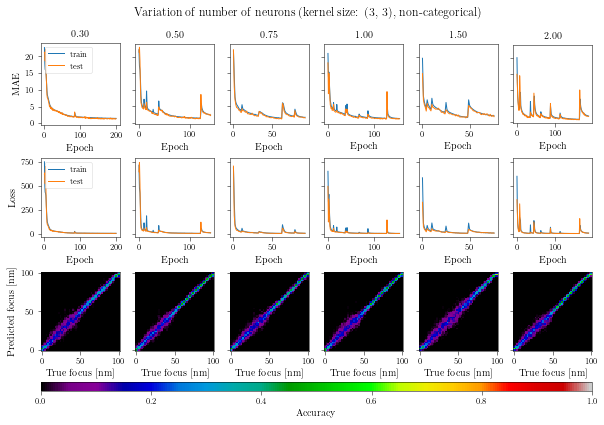

In [42]:
# Plot
fig, axs = plt.subplots(3, len(n_neurons), figsize=figsize(1.4, 0.6, textwidth), sharey='row')

nid = 'A#04'
scores = []
n_neurons = [0.3, 0.5, 0.75, 1.0, 1.5, 2.0]
drop = 0.05

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
for i, n in enumerate(n_neurons):
    print('----  {:.2f}  ----'.format(n))
    # Load the data
    H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), 
                     allow_pickle=True).item()
    
    try:
        Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n))
        model_loaded = False
        print('loaded y_pred')
    except:
        model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
        model_loaded = True
        Y_pred = model.predict(X_test[:])
        #Y_pred = defoci[np.argmax(Y_pred, axis=1)]
        print('Saved y_pred')
        np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), Y_pred)
    
    if scores_calc:
        if not model_loaded:
            model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
        score = model.evaluate(X_test, Y_test)
        scores.append(score)
        print('calculated score')
    print('Score: ', scores[i])
    
    # Accuracy
    axs[0, i].plot(H_conc['mean_absolute_error'], label='train')
    axs[0, i].plot(H_conc['val_mean_absolute_error'], label='test')
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_aspect(1.0/axs[0, i].get_data_ratio())
    
    # Loss
    axs[1, i].plot(H_conc['loss'], label='train')
    axs[1, i].plot(H_conc['val_loss'], label='test')
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_aspect(1.0/axs[1, i].get_data_ratio())
    
    # Confusion Matrix
    mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                           [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
    mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
    im = axs[2, i].imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)
    axs[2, i].set_xticks(defoci[::25]/C1_resolution)
    axs[2, i].set_yticks(defoci[::25]/C1_resolution)
    axs[2, i].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_xlabel('True focus [nm]')
    
    axs[0, i].set_title('{:.2f}'.format(n))
    
np.save('data/scores_{}.npy'.format(nid), scores)
print('saved score')

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='bottom', pad=0.05, width=0.02, cbar_label='Accuracy')
    
axs[0, 0].set_ylabel('MAE');
axs[1, 0].set_ylabel('Loss')
axs[2, 0].set_ylabel('Predicted focus [nm]')
axs[0, 0].legend(loc=2)
axs[1, 0].legend(loc=2)

fig.suptitle('Variation of number of neurons (kernel size: (3, 3), non-categorical)', y=0.95);

savefig('Images/Results_{}'.format(nid), formats=['png'], bbox_inches='tight')

In [ ]:
# Plot the model as a graph
nid = 'A#04'
plot_model(model, to_file='Images/model_{}.png'.format(nid), show_shapes=True)

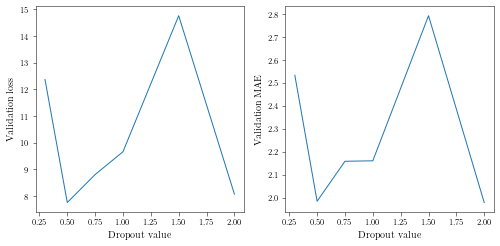

In [43]:
# Plot scores
nid = 'A#04'

fig, axs = plt.subplots(1, 2, figsize=figsize(1, 0.5, textwidth))
axs[0].plot(n_neurons, [s[0] for s in scores])
axs[0].set_xlabel('Dropout value')
axs[0].set_ylabel('Validation loss')

axs[1].plot(n_neurons, [s[1] for s in scores])
axs[1].set_xlabel('Dropout value')
axs[1].set_ylabel('Validation MAE');

fig.tight_layout()
savefig('Images/Scores_{}'.format(nid), formats=['png'], bbox_inches='tight')

## with negative defoci - kernel size 3, drop 0.05

In [103]:
# define the training parameters

# defocus
C1_max = 100
C1_resolution = 1
defoci = np.linspace(-C1_max, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (-C1_max, C1_max)

# training
n_processes = 20
n_batches = 500
ly = 10
dd = dd
n_fit_calls = 5

# write params in dictionaly
training_params = {}
training_params['C1_max'] = C1_max
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

In [104]:
# Build the model
n_classes = len(defoci)
n_epoch = 200
batch_size = 256

In [105]:
# Load data
try:
    X_train = np.load('data/X_train_20_500_10_45mrad_negativeC1.npy')
    Y_train = np.load('data/Y_train_20_500_10_45mrad_negativeC1.npy')
except:
    r = ronchi.RonchiTrainer(n_processes=n_processes, n_batches=600, ly=ly, dd=dd, thick_wobble=0.2,
                                     msa_obj=msa, ht=300, nx=nx, ny=ny, mtf='sim/Merlin-300keV-SPCM100.mtf')
    X_train, Y_train = r(aber_dict)

    np.save('data/X_train_20_500_10_45mrad_negativeC1.npy', X_train)
    np.save('data/Y_train_20_500_10_45mrad_negativeC1.npy', Y_train)

    r.finalize()

# Split apart a validation data set
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42, shuffle=True)

In [129]:
Y_val.shape

(9600,)

In [106]:
# Massive training search
nid = 'N#01'
n_neurons = 1
drop = 0.05
n = n_neurons
if input('Train model? (y or n)') == 'y':
#if True:
    
    # Build the model
    model = build_model_categorical(input_shape, n_classes, dropout=drop, n_neurons=n, 
                                    kernel_size=(3, 3), categorical=False)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n), 
                         monitor='val_loss', mode='min', save_best_only=True, verbose=1)

    # Prepare a list to save the history of the model
    H = []
    H_conc = {}

    # Save the training parameters
    np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), training_params)
    print(training_params)
    
    r = ronchi.RonchiTrainer(n_processes=n_processes, n_batches=600, ly=ly, dd=dd, thick_wobble=0.2,
                                     msa_obj=msa, ht=300, nx=nx, ny=ny, mtf='sim/Merlin-300keV-SPCM100.mtf')
    for it in range(n_fit_calls):
        if it != 0:
            X_train, Y_train = r(aber_dict)
            X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                              test_size=0.1, random_state=42, shuffle=True)
       
        H.append(model.fit(X_train, Y_train, 
                           batch_size=batch_size, 
                           epochs=n_epoch, 
                           verbose=1,
                           validation_data=(X_val, Y_val), 
                           #validation_split=0.1,
                           callbacks=[es, mc],
                           shuffle=True))
        
    r.finalize()

    # Concatanete the results for all training iterations and save them to dictionary    
    for key in H[0].history.keys():
        H_conc[key] = np.concatenate([h.history[key] for h in H])
    np.save('histories/{}_history_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), H_conc)

Train model? (y or n)


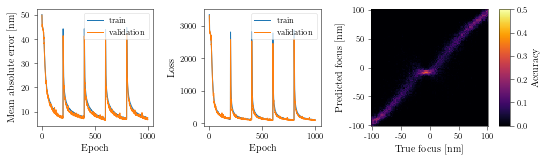

In [127]:
# Condensed plot
fig, axs = plt.subplots(1, 3, figsize=figsize(1, 0.4, textwidth))
nid = 'N#01'
n_neurons = 1
drop = 0.05
defoci = np.linspace(-C1_max, C1_max, 101)


H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n_neurons), 
                    allow_pickle=True).item()
    
Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n_neurons))



# Accuracy
axs[0].plot(H_conc['mean_absolute_error'], label='train')
axs[0].plot(H_conc['val_mean_absolute_error'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_aspect(1.0/axs[0].get_data_ratio())

# Loss
axs[1].plot(H_conc['loss'], label='train')
axs[1].plot(H_conc['val_loss'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_aspect(1.0/axs[1].get_data_ratio())

# Confusion Matrix
mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                       [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
#mat = confusion_matrix([int(y) for y in Y_test], 
#                       [int(y) for y in Y_pred])
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
im = axs[2].imshow(mat.T, origin='lower', cmap='inferno', vmin=0, vmax=0.5)
axs[2].set_xticks(defoci[::25]/2 + 50)
axs[2].set_yticks(defoci[::25]/2 + 50)
axs[2].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs[2].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs[2].set_xlabel('True focus [nm]')

#axs[0].set_title('{:.2f}'.format(drop))
#fig.suptitle('non-categorical data')

axs[0].set_ylabel('Mean absolute error [nm]');
axs[1].set_ylabel('Loss')
axs[2].set_ylabel('Predicted focus [nm]')
axs[0].legend(loc=1)
axs[1].legend(loc=1)

plt.tight_layout()

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='right', pad=0.01, width=0.02, cbar_label='Accuracy')

savefig('Images/Results_{}_condensed'.format(nid), formats=['png'], bbox_inches='tight')

loaded y_pred
Score:  [173.43030531   8.52733715]


/Users/fwinkler/.conda/envs/fw_tensorflow_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/Users/fwinkler/.conda/envs/fw_tensorflow_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


saved score


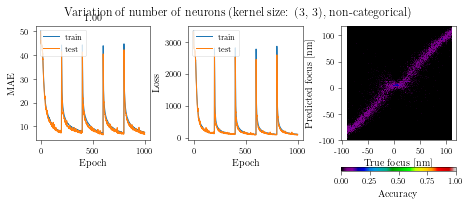

In [107]:
# Plot
fig, axs = plt.subplots(1, 3, figsize=figsize(0.9, 0.4, textwidth))

nid = 'N#01'
scores = []
n_neurons = 1
drop = 0.05

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
# Load the data
H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), 
                 allow_pickle=True).item()

try:
    Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n))
    model_loaded = False
    print('loaded y_pred')
except:
    model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
    model_loaded = True
    Y_pred = model.predict(X_test[:])
    #Y_pred = defoci[np.argmax(Y_pred, axis=1)]
    print('Saved y_pred')
    np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), Y_pred)

if scores_calc:
    if not model_loaded:
        model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
    score = model.evaluate(X_test, Y_test)
    scores.append(score)
    print('calculated score')
print('Score: ', scores[0])

# Accuracy
axs[0].plot(H_conc['mean_absolute_error'], label='train')
axs[0].plot(H_conc['val_mean_absolute_error'], label='test')
axs[0].set_xlabel('Epoch')
axs[0].set_aspect(1.0/axs[0].get_data_ratio())

# Loss
axs[1].plot(H_conc['loss'], label='train')
axs[1].plot(H_conc['val_loss'], label='test')
axs[1].set_xlabel('Epoch')
axs[1].set_aspect(1.0/axs[1].get_data_ratio())

# Confusion Matrix
mat = confusion_matrix([int(y) for y in Y_test], 
                       [int(y) for y in Y_pred])
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
im = axs[2].imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)
axs[2].set_xticks(defoci[::25]/C1_resolution + 100)
axs[2].set_yticks(defoci[::25]/C1_resolution + 100)
axs[2].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs[2].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs[2].set_xlabel('True focus [nm]')

axs[0].set_title('{:.2f}'.format(n))
    
np.save('data/scores_{}.npy'.format(nid), scores)
print('saved score')

# Colorbar
plt.tight_layout()
cb = pretty_colorbar(fig, axs[2], im, position='bottom', pad=0.05, width=0.02, cbar_label='Accuracy')
    
axs[0].set_ylabel('MAE');
axs[1].set_ylabel('Loss')
axs[2].set_ylabel('Predicted focus [nm]')
axs[0].legend(loc=2)
axs[1].legend(loc=2)

fig.suptitle('Variation of number of neurons (kernel size: (3, 3), non-categorical)', y=0.95);

savefig('Images/Results_{}'.format(nid), formats=['png'], bbox_inches='tight')

In [127]:
np.min(Y_test), np.max(Y_test)

(-99.95709609369396, 99.96028599305106)

In [128]:
np.min(Y_pred), np.max(Y_pred)

(-113.60797, 110.58078)

In [174]:
np.round(np.max(np.abs(Y_pred)), 0)

111.0

In [178]:
mat.shape

(210, 210)

In [138]:
Y_diff = Y_test - Y_pred.squeeze()

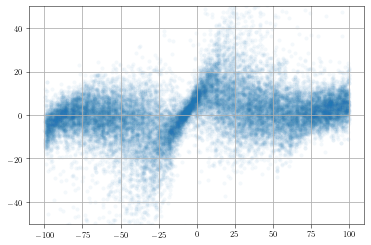

In [146]:
plt.scatter(Y_test, Y_diff, alpha=0.05, lw=0)
plt.ylim(-50, 50)
plt.grid()

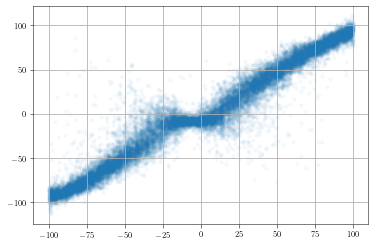

In [147]:
plt.scatter(Y_test, Y_pred, alpha=0.05, lw=0)
#plt.ylim(-50, 50)
plt.grid()

/Users/fwinkler/.conda/envs/fw_tensorflow_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/fwinkler/.conda/envs/fw_tensorflow_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


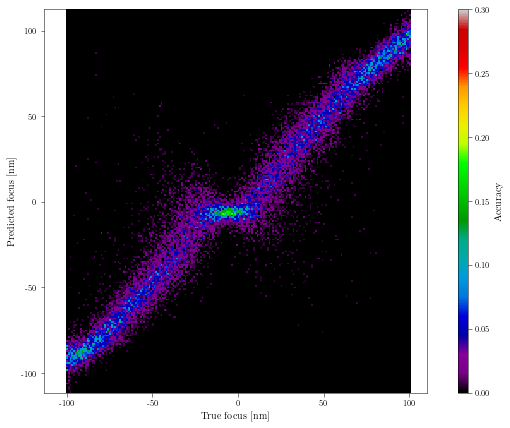

In [148]:
# Confusion Matrix
fig, axs = plt.subplots(1, 1, figsize=figsize(1, 1, textwidth))
mat = confusion_matrix([int(np.round(y, 0)) for y in Y_test], 
                       [int(np.round(y, 0)) for y in Y_pred])
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
im = axs.imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=0.3)
axs.set_xticks(defoci[::25]/C1_resolution - np.round(np.min(Y_pred), 0) - 1)
axs.set_yticks(defoci[::25]/C1_resolution + np.round(np.max(Y_pred), 0))
axs.set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs.set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
axs.set_xlabel('True focus [nm]')
axs.set_ylabel('Predicted focus [nm]')

#axs.set_xlim(-20 - np.round(np.min(Y_pred), 0), 20 - np.round(np.min(Y_pred), 0))
#axs.set_ylim(-20 - np.round(np.min(Y_pred), 0), 20 - np.round(np.min(Y_pred), 0))
    

# Colorbar
cb = pretty_colorbar(fig, axs, im, position='right', pad=0.05, width=0.02, cbar_label='Accuracy')

In [ ]:
# Plot the model as a graph
nid = 'N#01'
plot_model(model, to_file='Images/model_{}.png'.format(nid), show_shapes=True)

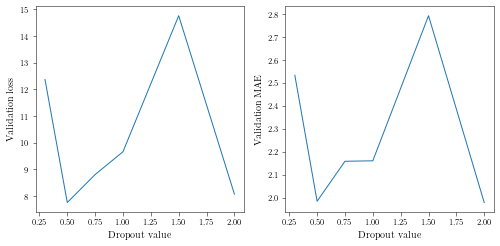

In [43]:
# Plot scores
nid = 'N#01'

fig, axs = plt.subplots(1, 2, figsize=figsize(1, 0.5, textwidth))
axs[0].plot(n_neurons, [s[0] for s in scores])
axs[0].set_xlabel('Dropout value')
axs[0].set_ylabel('Validation loss')

axs[1].plot(n_neurons, [s[1] for s in scores])
axs[1].set_xlabel('Dropout value')
axs[1].set_ylabel('Validation MAE');

fig.tight_layout()
savefig('Images/Scores_{}'.format(nid), formats=['png'], bbox_inches='tight')

## More layers - non categorical

In [44]:
def build_model_categorical_2(input_shape, n_classes, n_neurons=1.0, dropout=0.2, kernel_size=(5, 5), 
                            categorical=True):
    model = Sequential()
    model.add(Conv2D(int(32*n_neurons), kernel_size=kernel_size, padding="same", input_shape=input_shape, 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format='channels_first'))
    model.add(Dropout(dropout))

    model.add(Conv2D(int(64*n_neurons), kernel_size=kernel_size, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first"))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(int(128*n_neurons), kernel_size=kernel_size, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first"))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(int(160*n_neurons), kernel_size=kernel_size, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first"))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(int(160*n_neurons), kernel_size=kernel_size, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first"))
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(int(400*n_neurons), activation='relu'))
    
    if categorical:
        model.add(Dense(n_classes), activation='softmax')
    else:
        model.add(Dense(int(200*n_neurons), activation='relu'))
        model.add(Dense(1))
    return model

In [45]:
# define the training parameters

# defocus
C1_max = 100
C1_resolution = 1
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (0, C1_max)

# training
n_processes = 20
n_batches = 500
ly = 10
dd = dd
n_fit_calls = 1

# write params in dictionaly
training_params = {}
training_params['C1_max'] = C1_max
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

# model params
n_classes = len(defoci)
n_epoch = 250
batch_size = 256

In [46]:
# Massive training search
nid = 'A#05'
n_neurons = [0.5, 1.0]
drops = [0.05, 0.1]
if input('Train model? (y or n)') == 'y':
    for n in n_neurons:
        for drop in drops:
            print('---------------')
            print('number of neurons: {:.2f}'.format(n))
            print('dropout value: {:.2f}'.format(drop))
            print('---------------')

            # Build the model
            model = build_model_categorical_2(input_shape, n_classes, dropout=drop, n_neurons=n, 
                                              kernel_size=(3, 3), categorical=False)
            model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
            mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n), 
                                 monitor='val_loss', mode='min', save_best_only=True, verbose=1)

            # Prepare a list to save the history of the model
            H = []
            H_conc = {}

            # Save the training parameters
            np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), training_params)
            print(training_params)

            H.append(model.fit(X_train, Y_train, 
                               batch_size=batch_size, 
                               epochs=n_epoch, 
                               verbose=1,
                               validation_data=(X_val, Y_val), 
                               #validation_split=0.1,
                               callbacks=[es, mc],
                               shuffle=True))

            # Concatanete the results for all training iterations and save them to dictionary    
            for key in H[0].history.keys():
                H_conc[key] = np.concatenate([h.history[key] for h in H])
            np.save('histories/{}_history_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), H_conc)

Train model? (y or n)


----  0.50  ----
loaded y_pred
Score:  [6.32700564 1.81746422]
----  0.50  ----
loaded y_pred
Score:  [6.32700564 1.81746422]
----  1.00  ----
loaded y_pred
Score:  [26.24342703  3.8523808 ]
----  1.00  ----
loaded y_pred
Score:  [26.24342703  3.8523808 ]
saved score


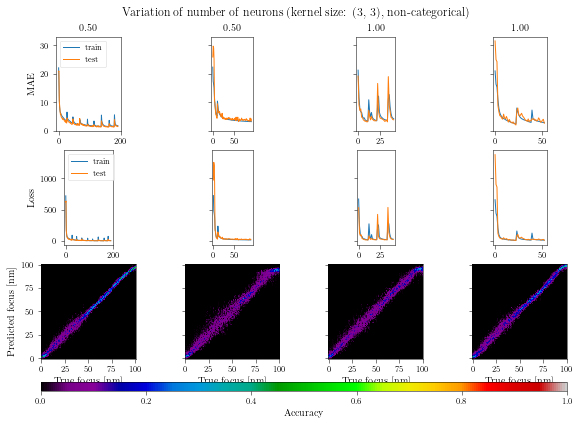

In [47]:
# Plot
fig, axs = plt.subplots(3, 4, figsize=figsize(1.4, 0.6, textwidth), sharey='row')

nid = 'A#05'
scores = []
n_neurons = [0.5, 1.0]
drops = [0.05, 0.1]

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
for i, n in enumerate(n_neurons):
    for j, drop in enumerate(drops):
        print('----  {:.2f}  ----'.format(n))
        # Load the data
        H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), 
                         allow_pickle=True).item()

        try:
            Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n))
            model_loaded = False
            print('loaded y_pred')
        except:
            model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
            model_loaded = True
            Y_pred = model.predict(X_test[:])
            #Y_pred = defoci[np.argmax(Y_pred, axis=1)]
            print('Saved y_pred')
            np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), Y_pred)

        if scores_calc:
            if not model_loaded:
                model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
            score = model.evaluate(X_test, Y_test)
            scores.append(score)
            print('calculated score')
        print('Score: ', scores[i])
        
        if (i == 0) & (j == 0):
            k = 0
        elif (i == 0) & (j == 1):
            k = 1
        elif (i == 1) & (j == 0):
            k = 2
        else:
            k = 3
            
        # Accuracy
        axs[0, k].plot(H_conc['mean_absolute_error'], label='train')
        axs[0, k].plot(H_conc['val_mean_absolute_error'], label='test')
        axs[0, k].set_xlabel('Epoch')
        axs[0, k].set_aspect(1.0/axs[0, i].get_data_ratio())

        # Loss
        axs[1, k].plot(H_conc['loss'], label='train')
        axs[1, k].plot(H_conc['val_loss'], label='test')
        axs[1, k].set_xlabel('Epoch')
        axs[1, k].set_aspect(1.0/axs[1, i].get_data_ratio())

        # Confusion Matrix
        mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                               [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
        mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
        im = axs[2, k].imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)
        axs[2, k].set_xticks(defoci[::25]/C1_resolution)
        axs[2, k].set_yticks(defoci[::25]/C1_resolution)
        axs[2, k].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
        axs[2, k].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
        axs[2, k].set_xlabel('True focus [nm]')

        axs[0, k].set_title('{:.2f}'.format(n))
    
np.save('data/scores_{}.npy'.format(nid), scores)
print('saved score')

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='bottom', pad=0.05, width=0.02, cbar_label='Accuracy')
    
axs[0, 0].set_ylabel('MAE');
axs[1, 0].set_ylabel('Loss')
axs[2, 0].set_ylabel('Predicted focus [nm]')
axs[0, 0].legend(loc=2)
axs[1, 0].legend(loc=2)

fig.suptitle('Variation of number of neurons (kernel size: (3, 3), non-categorical)', y=0.95);

savefig('Images/Results_{}'.format(nid), formats=['png'], bbox_inches='tight')

In [ ]:
# Plot the model as a graph
nid = 'A#05'
plot_model(model, to_file='Images/model_{}.png'.format(nid), show_shapes=True)

ValueError: x and y must have same first dimension, but have shapes (2,) and (4,)

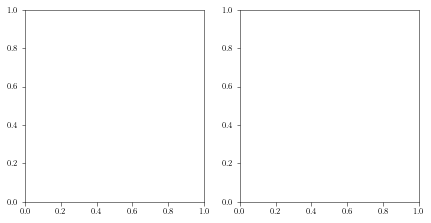

In [48]:
# Plot scores
nid = 'A#04'

fig, axs = plt.subplots(1, 2, figsize=figsize(1, 0.5, textwidth))
axs[0].plot(n_neurons, [s[0] for s in scores])
axs[0].set_xlabel('Dropout value')
axs[0].set_ylabel('Validation loss')

axs[1].plot(n_neurons, [s[1] for s in scores])
axs[1].set_xlabel('Dropout value')
axs[1].set_ylabel('Validation MAE');

fig.tight_layout()
savefig('Images/Scores_{}'.format(nid), formats=['png'], bbox_inches='tight')

# Include Astigmatism

In [49]:
def build_model_categorical_3(input_shape, n_classes, n_neurons=1.0, dropout=0.2, kernel_size=(5, 5), 
                            categorical=True):
    model = Sequential()
    model.add(Conv2D(int(32*n_neurons), kernel_size=kernel_size, padding="same", input_shape=input_shape, 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format='channels_first'))
    model.add(Dropout(dropout))

    model.add(Conv2D(int(64*n_neurons), kernel_size=kernel_size, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first"))
    model.add(Dropout(dropout))
    
    model.add(Conv2D(int(128*n_neurons), kernel_size=kernel_size, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first"))
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(int(400*n_neurons), activation='relu'))
    
    if categorical:
        model.add(Dense(n_classes), activation='softmax')
    else:
        model.add(Dense(int(200*n_neurons), activation='relu'))
        model.add(Dense(3))
    return model

## Smaller C1

In [59]:
# define the training parameters

# defocus
C1_max = 20
A1_max = 10
C1_resolution = 1
A1_resolution = 0.1
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (0, C1_max)
aber_dict['A1'] = (-A1_max, A1_max)

# training
n_processes = 20
n_batches = 400
ly = 10
dd = dd
n_fit_calls = 5

# write params in dictionaly
training_params = {}
training_params['aber_dict'] = aber_dict
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

# model params
n_classes = len(defoci)
n_epoch = 250
batch_size = 256

In [68]:
# Load or calculate training data set (100.000 images)
if input('Load test data? (y or n)') == 'y':
    X_test = np.load('data/X_test_20_100_10_45mrad_{}.npy'.format(nid))
    Y_test = np.load('data/Y_test_20_100_10_45mrad_{}.npy'.format(nid))
else:
    r = ronchi.RonchiTrainer(n_processes=n_processes, n_batches=100, ly=ly, dd=dd, thick_wobble=0.2,
                                 msa_obj=msa, ht=300, nx=nx, ny=ny, mtf='sim/Merlin-300keV-SPCM100.mtf')
    X_test, Y_test = r(aber_dict)
    
    r.finalize()
    np.save('data/X_test_20_100_10_45mrad_{}.npy'.format(nid), X_test)
    np.save('data/Y_test_20_100_10_45mrad_{}.npy'.format(nid), Y_test)

Load test data? (y or n)y


In [51]:
# Massive training search
nid = 'F#01'
n_neurons = [1, 2, 4]
drop = 0.05
if input('Train model? (y or n)') == 'y':
    for n in n_neurons:
        # Build the model
        model = build_model_categorical_3(input_shape, n_classes, dropout=drop, n_neurons=n, 
                                          kernel_size=(3, 3), categorical=False)
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
        mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n), 
                             monitor='val_loss', mode='min', save_best_only=True, verbose=1)

        # Prepare a list to save the history of the model
        H = []
        H_conc = {}

        # Save the training parameters
        np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), training_params)
        print(training_params)

        r = ronchi.RonchiTrainer(n_processes=n_processes, n_batches=n_batches, ly=ly, dd=dd, thick_wobble=0.2,
                                 msa_obj=msa, ht=300, nx=nx, ny=ny, mtf='sim/Merlin-300keV-SPCM100.mtf')
        for i in range(n_fit_calls):
            print('--------{}--------'.format(i))
            X_train, Y_train = r(aber_dict)

            H.append(model.fit(X_train, Y_train, 
                               batch_size=batch_size, 
                               epochs=n_epoch, 
                               verbose=1,
                               #validation_data=(X_val, Y_val), 
                               validation_split=0.1,
                               callbacks=[es, mc],
                               shuffle=True))

        # Concatanete the results for all training iterations and save them to dictionary    
        for key in H[0].history.keys():
            H_conc[key] = np.concatenate([h.history[key] for h in H])
        np.save('histories/{}_history_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), H_conc)

Train model? (y or n)


In [77]:
nid = 'F#01'
n_neurons = [1, 2, 4]
drop = 0.05

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
for i, n in enumerate(n_neurons):
    print('----  {:.2f}  ----'.format(n))
    # Load the data
    H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), 
                     allow_pickle=True).item()
    try:
        Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n))
        model_loaded = False
        print('loaded y_pred')
    except:
        model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
        model_loaded = True
        Y_pred = model.predict(X_test[:])
        #Y_pred = defoci[np.argmax(Y_pred, axis=1)]
        print('Saved y_pred')
        np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), Y_pred)
        
    if scores_calc:
        if not model_loaded:
            model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
        score = model.evaluate(X_test, Y_test)
        scores.append(score)
        print('calculated score')
    print('Score: ', scores[i])

----  1.00  ----
loaded y_pred
20000/20000 [==============================] - 9s 465us/step
calculated score
Score:  [3.2307321040153503, 1.3764389814376832]
----  2.00  ----
loaded y_pred
20000/20000 [==============================] - 5s 229us/step
calculated score
Score:  [3.3614859569549562, 1.407925053691864]
----  4.00  ----
loaded y_pred
20000/20000 [==============================] - 5s 248us/step
calculated score
Score:  [3.2835863934516905, 1.4009075325012208]


In [80]:
Y_test[:20, 0]

array([14.70432238, 14.70432238, 14.70432238, 14.70432238, 14.70432238,
       14.70432238, 14.70432238, 14.70432238, 14.70432238, 14.70432238,
       11.61373243, 11.61373243, 11.61373243, 11.61373243, 11.61373243,
       11.61373243, 11.61373243, 11.61373243, 11.61373243, 11.61373243])

In [95]:
C1_resolution = 0.5
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))

In [98]:
asti = np.linspace(-A1_max, A1_max, int(A1_max / A1_resolution + 1))

In [101]:
asti*10

array([-100.,  -98.,  -96.,  -94.,  -92.,  -90.,  -88.,  -86.,  -84.,
        -82.,  -80.,  -78.,  -76.,  -74.,  -72.,  -70.,  -68.,  -66.,
        -64.,  -62.,  -60.,  -58.,  -56.,  -54.,  -52.,  -50.,  -48.,
        -46.,  -44.,  -42.,  -40.,  -38.,  -36.,  -34.,  -32.,  -30.,
        -28.,  -26.,  -24.,  -22.,  -20.,  -18.,  -16.,  -14.,  -12.,
        -10.,   -8.,   -6.,   -4.,   -2.,    0.,    2.,    4.,    6.,
          8.,   10.,   12.,   14.,   16.,   18.,   20.,   22.,   24.,
         26.,   28.,   30.,   32.,   34.,   36.,   38.,   40.,   42.,
         44.,   46.,   48.,   50.,   52.,   54.,   56.,   58.,   60.,
         62.,   64.,   66.,   68.,   70.,   72.,   74.,   76.,   78.,
         80.,   82.,   84.,   86.,   88.,   90.,   92.,   94.,   96.,
         98.,  100.])

In [103]:
[int(10*asti[np.argmin(np.abs(y - asti))]) for y in Y_test[:, 1]]

[68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 -38,
 -38,
 -38,
 -38,
 -38,
 -38,
 -38,
 -38,
 -38,
 -38,
 -98,
 -98,
 -98,
 -98,
 -98,
 -98,
 -98,
 -98,
 -98,
 -98,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 -7,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 -23,
 -23,
 -23,
 -23,
 -23,
 -23,
 -23,
 -23,
 -23,
 -23,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 -84,
 -84,
 -84,
 -84,
 -84,
 -84,
 -84,
 -84,
 -84,
 -84,
 -78,
 -78,
 -78,
 -78,
 -78,
 -78,
 -78,
 -78,
 -78,
 -78,
 -68,
 -68,
 -68,
 -68,
 -68,
 -68,
 -68,
 -68,
 -68,
 -68,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 -58,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 -82,
 -82,
 -82,
 -82,
 -82,


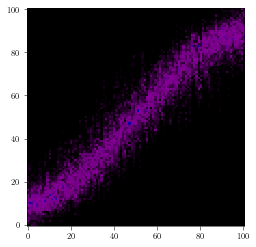

In [105]:
mat = confusion_matrix([int(10*asti[np.argmin(np.abs(y - asti))]) for y in Y_test[:, 2]], 
                       [int(10*asti[np.argmin(np.abs(y - asti))]) for y in Y_pred[:, 2]])


mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
im = plt.imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)

----  0.50  ----
loaded y_pred
Score:  [6.32700564 1.81746422]
----  0.50  ----
loaded y_pred
Score:  [6.32700564 1.81746422]
----  1.00  ----
loaded y_pred
Score:  [26.24342703  3.8523808 ]
----  1.00  ----
loaded y_pred
Score:  [26.24342703  3.8523808 ]
saved score


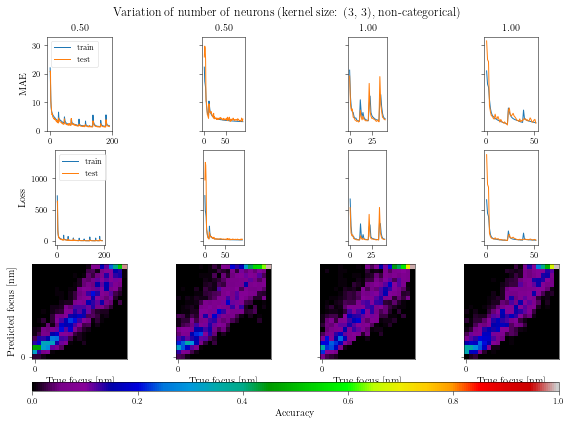

In [53]:
# Plot
fig, axs = plt.subplots(3, 4, figsize=figsize(1.4, 0.6, textwidth), sharey='row')

nid = 'A#05'
scores = []
n_neurons = [0.5, 1.0]
drops = [0.05, 0.1]

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
for i, n in enumerate(n_neurons):
    for j, drop in enumerate(drops):
        print('----  {:.2f}  ----'.format(n))
        # Load the data
        H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), 
                         allow_pickle=True).item()

        try:
            Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n))
            model_loaded = False
            print('loaded y_pred')
        except:
            model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
            model_loaded = True
            Y_pred = model.predict(X_test[:])
            #Y_pred = defoci[np.argmax(Y_pred, axis=1)]
            print('Saved y_pred')
            np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n), Y_pred)

        if scores_calc:
            if not model_loaded:
                model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n))
            score = model.evaluate(X_test, Y_test)
            scores.append(score)
            print('calculated score')
        print('Score: ', scores[i])
        
        if (i == 0) & (j == 0):
            k = 0
        elif (i == 0) & (j == 1):
            k = 1
        elif (i == 1) & (j == 0):
            k = 2
        else:
            k = 3
            
        # Accuracy
        axs[0, k].plot(H_conc['mean_absolute_error'], label='train')
        axs[0, k].plot(H_conc['val_mean_absolute_error'], label='test')
        axs[0, k].set_xlabel('Epoch')
        axs[0, k].set_aspect(1.0/axs[0, i].get_data_ratio())

        # Loss
        axs[1, k].plot(H_conc['loss'], label='train')
        axs[1, k].plot(H_conc['val_loss'], label='test')
        axs[1, k].set_xlabel('Epoch')
        axs[1, k].set_aspect(1.0/axs[1, i].get_data_ratio())

        # Confusion Matrix
        mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                               [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
        mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
        im = axs[2, k].imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)
        axs[2, k].set_xticks(defoci[::25]/C1_resolution)
        axs[2, k].set_yticks(defoci[::25]/C1_resolution)
        axs[2, k].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
        axs[2, k].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
        axs[2, k].set_xlabel('True focus [nm]')

        axs[0, k].set_title('{:.2f}'.format(n))
    
np.save('data/scores_{}.npy'.format(nid), scores)
print('saved score')

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='bottom', pad=0.05, width=0.02, cbar_label='Accuracy')
    
axs[0, 0].set_ylabel('MAE');
axs[1, 0].set_ylabel('Loss')
axs[2, 0].set_ylabel('Predicted focus [nm]')
axs[0, 0].legend(loc=2)
axs[1, 0].legend(loc=2)

fig.suptitle('Variation of number of neurons (kernel size: (3, 3), non-categorical)', y=0.95);

savefig('Images/Results_{}'.format(nid), formats=['png'], bbox_inches='tight')

In [57]:
Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}.npy'.format(nid, drop, n))

In [58]:
Y_pred

array([[88.1101  ],
       [89.49982 ],
       [89.12493 ],
       ...,
       [52.792835],
       [52.71333 ],
       [52.848366]], dtype=float32)

## also negative C1

In [27]:
# define the training parameters

# defocus
C1_max = 10
A1_max = 10
C1_resolution = 1
A1_resolution = 0.1
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (-C1_max, C1_max)
aber_dict['A1'] = (-A1_max, A1_max)

# training
n_processes = 20
n_batches = 400
ly = 10
dd = dd
n_fit_calls = 5

# write params in dictionaly
training_params = {}
training_params['aber_dict'] = aber_dict
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

# model params
n_classes = len(defoci)
n_epoch = 250
batch_size = 256

In [ ]:
# Massive training search
nid = 'F#02'
n_neurons = [1, 2, 4]
drop = 0.05
#if input('Train model? (y or n)') == 'y':
if True:
    for n in n_neurons:
        # Build the model
        model = build_model_categorical_3(input_shape, n_classes, dropout=drop, n_neurons=n, 
                                          kernel_size=(3, 3), categorical=False)
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
        mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}.h5'.format(nid, drop, n), 
                             monitor='val_loss', mode='min', save_best_only=True, verbose=1)

        # Prepare a list to save the history of the model
        H = []
        H_conc = {}

        # Save the training parameters
        np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), training_params)
        print(training_params)

        r = ronchi.RonchiTrainer(n_processes=n_processes, n_batches=n_batches, ly=ly, dd=dd, thick_wobble=0.2,
                                 msa_obj=msa, ht=300, nx=nx, ny=ny, mtf='sim/Merlin-300keV-SPCM100.mtf')
        for i in range(n_fit_calls):
            print('--------{}--------'.format(i))
            X_train, Y_train = r(aber_dict)

            H.append(model.fit(X_train, Y_train, 
                               batch_size=batch_size, 
                               epochs=n_epoch, 
                               verbose=1,
                               #validation_data=(X_val, Y_val), 
                               validation_split=0.1,
                               callbacks=[es, mc],
                               shuffle=True))

        # Concatanete the results for all training iterations and save them to dictionary    
        for key in H[0].history.keys():
            H_conc[key] = np.concatenate([h.history[key] for h in H])
        np.save('histories/{}_history_drop{:.2f}_nn{:.1f}'.format(nid, drop, n), H_conc)

{'aber_dict': {'A0': 0j, 'A1': (-10, 10), 'C1': (-10, 10), 'A2': 0j, 'B2': 0j, 'A3': 0j, 'C3': 0j, 'S3': 0j, 'A4': 0j, 'B4': 0j, 'D4': 0j, 'C5': 0j}, 'C1_resolution': 1, 'n_processes': 20, 'n_batches': 400, 'ly': 10, 'dd': 81, 'n_fit_calls': 5}
--------0--------


# Multiple fit calls

In [ ]:
# define the training parameters

# defocus
C1_max = 100
C1_resolution = 2
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (0, C1_max)

# training
n_processes = 30
n_batches = 250
ly = 10
dd = dd
n_fit_calls = 8

# write params in dictionaly
training_params = {}
training_params['C1_max'] = C1_max
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

In [ ]:
# Build the model
n_classes = len(defoci)
n_epoch = 200
batch_size = 250

In [ ]:
# Massive training search
nid = 'D#01'
n_neurons = 1
drops = [0.10, 0.15, 0.2]

if input('Train model? (y or n)') == 'y':
    for drop in drops:
        # Build the model
        model = build_model_categorical(input_shape, n_classes, dropout=drop, n_neurons=n_neurons, 
                                        kernel_size=(3, 3))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons), 
                             monitor='val_loss', mode='min', save_best_only=True, verbose=1)

        # Prepare a list to save the history of the model
        H = []
        H_conc = {}

        # Save the training parameters
        np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}_categorical'.format(nid, drop, n_neurons), training_params)
        print(training_params)

        r = ronchi.RonchiTrainer(n_processes=n_processes, n_batches=n_batches, ly=ly, dd=dd, thick_wobble=0.2,
                                 msa_obj=msa, ht=300, nx=nx, ny=ny, mtf='sim/Merlin-300keV-SPCM100.mtf')
        for it in range(n_fit_calls):
            if it != 0:
                X_train, Y_train = r(aber_dict)
            H.append(model.fit(X_train, categorical(Y_train, defoci), 
                               batch_size=batch_size, 
                               epochs=n_epoch, 
                               verbose=1,
                               validation_data=(X_test, categorical(Y_test, defoci)), 
                               callbacks=[es, mc],
                               shuffle=True))

        # Concatanete the results for all training iterations and save them to dictionary    
        for key in H[0].history.keys():
            H_conc[key] = np.concatenate([h.history[key] for h in H])
        np.save('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical'.format(nid, drop, n_neurons), H_conc)

In [ ]:
# Plot
fig, axs = plt.subplots(3, 3, figsize=figsize(1.4, 1.2, textwidth), sharey='row')

nid = 'D#01'
n_neurons = 1
scores = []

if os.path.isfile('data/scores_{}.npy'.format(nid)):
    scores = np.load('data/scores_{}.npy'.format(nid))
    scores_calc = False
else:
    scores = []
    scores_calc = True
    
for i, drop in enumerate(drops):
    print('----  {:.2f}  ----'.format(drop))
    # Load the data
    H_conc = np.load('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), 
                     allow_pickle=True).item()
    
    try:
        Y_pred = np.load('data/predicted_{}_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons))
        model_loaded = False
        print('loaded y_pred')
    except:
        model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons))
        model_loaded = True
        Y_pred = model.predict(X_test[:])
        Y_pred = defoci[np.argmax(Y_pred, axis=1)]
        print('Saved y_pred')
        np.save('data/predicted_{}_drop{:.2f}_nn{:.1f}_categorical.npy'.format(nid, drop, n_neurons), Y_pred)
    
    if scores_calc:
        if not model_loaded:
            model = load_model('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons))
        score = model.evaluate(X_test, categorical(Y_test, defoci))
        scores.append(score)
        print('calculated score')
    print('Score: ', scores[i])
    
    # Accuracy
    axs[0, i].plot(H_conc['acc'], label='train')
    axs[0, i].plot(H_conc['val_acc'], label='test')
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_aspect(1.0/axs[0, i].get_data_ratio())
    
    # Loss
    axs[1, i].plot(H_conc['loss'], label='train')
    axs[1, i].plot(H_conc['val_loss'], label='test')
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_aspect(1.0/axs[1, i].get_data_ratio())
    
    # Confusion Matrix
    mat = confusion_matrix([defoci[np.argmin(np.abs(y - defoci))] for y in Y_test], 
                           [defoci[np.argmin(np.abs(y - defoci))] for y in Y_pred])
    mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
    im = axs[2, i].imshow(mat.T, origin='lower', cmap='nipy_spectral', vmin=0, vmax=1)
    axs[2, i].set_xticks(defoci[::25]/C1_resolution)
    axs[2, i].set_yticks(defoci[::25]/C1_resolution)
    axs[2, i].set_xticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_yticklabels(['{:.0f}'.format(f) for f in defoci[::25]])
    axs[2, i].set_xlabel('True focus [nm]')
    
    axs[0, i].set_title('{:.2f}'.format(drop))
    
np.save('data/scores_{}.npy'.format(nid), scores)
print('saved score')

# Colorbar
cb = pretty_colorbar(fig, axs[2], im, position='bottom', pad=0.05, width=0.02, cbar_label='Accuracy')
    
axs[0, 0].set_ylabel('Accuracy');
axs[1, 0].set_ylabel('Loss')
axs[2, 0].set_ylabel('Predicted focus [nm]')
axs[0, 0].legend(loc=2)
axs[1, 0].legend(loc=2)

fig.suptitle('Variation of dropout value (kernel size: (3, 3))', y=0.95);

savefig('Images/Results_{}'.format(nid), formats=['png'], bbox_inches='tight')

In [ ]:
# Plot the model as a graph
nid = 'D#01'
plot_model(model, to_file='Images/model_{}.png'.format(nid), show_shapes=True)

In [ ]:
# Plot scores
nid = 'D#01'

fig, axs = plt.subplots(1, 2, figsize=figsize(1, 0.5, textwidth))
axs[0].plot(drops, [s[0] for s in scores])
axs[0].set_xlabel('Dropout value')
axs[0].set_ylabel('Validation loss')

axs[1].plot(drops, [s[1] for s in scores])
axs[1].set_xlabel('Dropout value')
axs[1].set_ylabel('Validation accuracy');

fig.tight_layout()
savefig('Images/Scores_{}'.format(nid), formats=['png'], bbox_inches='tight')

# As regression

# Testing data augmentation

In [ ]:
# define the training parameters

# defocus
C1_max = 100
C1_resolution = 2
defoci = np.linspace(0, C1_max, int(C1_max / C1_resolution + 1))
aber_dict = ronchi.create_empty_aber_dict()
aber_dict['C1'] = (0, C1_max)

# training
n_processes = 20
n_batches = 500
ly = 10
dd = dd
n_fit_calls = 1

# write params in dictionaly
training_params = {}
training_params['C1_max'] = C1_max
training_params['C1_resolution'] = C1_resolution
training_params['n_processes'] = n_processes
training_params['n_batches'] = n_batches
training_params['ly'] = ly
training_params['dd'] = dd
training_params['n_fit_calls'] = n_fit_calls

In [ ]:
# Build the model
n_classes = len(defoci)
n_epoch = 200
batch_size = 250

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen

In [ ]:
datagen.fit(X_train)

In [ ]:
# Massive training search
nid = 'C#01'
drop = 0.15
n_neurons = 1.0

if input('Train model? (y or n)') == 'y':
    # Build the model
    model = build_model_categorical(input_shape, n_classes, dropout=drop, n_neurons=n_neurons, 
                                    kernel_size=(3, 3))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
    mc = ModelCheckpoint('models/{}_model_drop{:.2f}_nn{:.1f}_categorical.h5'.format(nid, drop, n_neurons), 
                         monitor='val_loss', mode='min', save_best_only=True, verbose=1)

    # Prepare a list to save the history of the model
    H = []
    H_conc = {}

    # Save the training parameters
    np.save('training_params/{}_tp_drop{:.2f}_nn{:.1f}_categorical'.format(nid, drop, n_neurons), 
            training_params)
    print(training_params)

    datagen = ImageDataGenerator(rotation_range=0,
                                 zca_epsilon=1e-06,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.0,
                                 zoom_range=0.0,
                                 fill_mode='nearest',
                                 data_format='channels_first',
                                 horizontal_flip=False)
    
    datagen.fit(X_train)
    
    H.append(model.fit_generator(datagen.flow(X_train, categorical(Y_train, defoci), batch_size=batch_size),
                                 steps_per_epoch=50,
                                 #batch_size=batch_size, 
                                 epochs=n_epoch, 
                                 verbose=1,
                                 validation_data=(X_test, categorical(Y_test, defoci)), 
                                 callbacks=[es, mc],
                                 shuffle=True))
    

    # Concatanete the results for all training iterations and save them to dictionary    
    for key in H[0].history.keys():
        H_conc[key] = np.concatenate([h.history[key] for h in H])
    np.save('histories/{}_history_drop{:.2f}_nn{:.1f}_categorical'.format(nid, drop, n_neurons), H_conc)

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=0,
                             zca_epsilon=1e-06,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.02,
                             zoom_range=0.02,
                             fill_mode='nearest',
                             horizontal_flip=False)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, categorical(Y_train, defoci), batch_size=batch_size),
                    #batch_size=batch_size, 
                    epochs=n_epoch, 
                    verbose=1,
                    validation_data=(X_test, categorical(Y_test, defoci)), 
                    callbacks=[es, mc],
                    shuffle=True)

In [ ]:


test_datagen = ImageDataGenerator()#rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    #target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        #target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)




In [ ]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)